# 3_CNN_Model.ipynb – CNN-Based Multi-Modal Model

In this notebook, I’ll build and train a CNN-based multi-modal model for loan approval prediction. The tabular data will be reshaped and passed through 1D convolution layers, while the text branch will use the same BERT encoder. Both branches will be fused before the final prediction.


# Step 1: Load Sampled Data and Prepare Inputs

I’ll start by loading the cleaned and balanced 20k sample dataset, then separate the text column, tabular features, and target label. I’ll also reshape the tabular features so they can be used with 1D CNN layers.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
data_path = '/content/drive/MyDrive/LoanApprovalProject/Data/loan_data_sampled.csv'
df = pd.read_csv(data_path)

# Separate features
X_tabular = df.drop(['loan_status', 'text'], axis=1)
X_text = df['text']
y = df['loan_status']

from sklearn.model_selection import train_test_split
X_tab_train, X_tab_temp, X_text_train, X_text_temp, y_train, y_temp = train_test_split(
    X_tabular, X_text, y, test_size=0.4, stratify=y, random_state=42)

X_tab_val, X_tab_test, X_text_val, X_text_test, y_val, y_test = train_test_split(
    X_tab_temp, X_text_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_tab_train.shape, "Val:", X_tab_val.shape, "Test:", X_tab_test.shape)


Mounted at /content/drive
Train: (12000, 12) Val: (4000, 12) Test: (4000, 12)


# Step 2: Preprocess and Reshape Tabular Data for CNN

To prepare tabular data for Conv1D layers, I first scale numerical features and apply one-hot encoding to categorical ones.  
Then, I reshape the resulting 2D array into a 3D format of shape `(samples, features, 1)`, which is required by Conv1D layers.


In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import joblib


# Identify column types
categorical_cols = ['term', 'grade', 'emp_title', 'home_ownership', 'verification_status']
numerical_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'revol_util', 'fico_range_high']

# Numerical pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
tabular_transformer = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


# Transform and reshape
X_tab_train_processed = tabular_transformer.fit_transform(X_tab_train).toarray()
X_tab_val_processed   = tabular_transformer.transform(X_tab_val).toarray()
X_tab_test_processed  = tabular_transformer.transform(X_tab_test).toarray()

# Save CNN preprocessor for SHAP
joblib.dump(tabular_transformer, '/content/drive/MyDrive/LoanApprovalProject/Code/cnn_preprocessor.joblib')
print("CNN preprocessor saved.")

# Reshape to (samples, features, 1)
X_tab_train_cnn = X_tab_train_processed.reshape((X_tab_train_processed.shape[0], X_tab_train_processed.shape[1], 1))
X_tab_val_cnn   = X_tab_val_processed.reshape((X_tab_val_processed.shape[0], X_tab_val_processed.shape[1], 1))
X_tab_test_cnn  = X_tab_test_processed.reshape((X_tab_test_processed.shape[0], X_tab_test_processed.shape[1], 1))


CNN preprocessor saved.


# Step 3: Tokenize Text for CNN Model (BERT Input)

Now I’ll tokenize the text input using the same BERT tokenizer. These tokenized outputs will be used in the text branch of the CNN-based multi-modal model.


In [3]:
!pip install -q transformers

from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize helper
def tokenize_texts(texts, max_len=64):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='np'
    )

# Tokenize
X_text_train_tok = tokenize_texts(X_text_train)
X_text_val_tok   = tokenize_texts(X_text_val)
X_text_test_tok  = tokenize_texts(X_text_test)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Step 4: Build the CNN-Based Multi-Modal Model

This model uses a Conv1D-based branch for the reshaped tabular input and a frozen BERT encoder for the text branch. Both branches are fused and passed through dense layers for binary classification.


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, Lambda
from tensorflow.keras.models import Model
from transformers import TFBertModel

# Tabular CNN branch
x_tab = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(tab_input)
x_tab = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x_tab)
x_tab = GlobalMaxPooling1D()(x_tab)
x_tab = Dense(32, activation='relu')(x_tab)

# Text (BERT) branch
text_input_ids = Input(shape=(64,), dtype=tf.int32, name='input_ids')
text_attention = Input(shape=(64,), dtype=tf.int32, name='attention_mask')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = False

def get_bert_output(inputs):
    input_ids, attention_mask = inputs
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.pooler_output

# Use Lambda layer to wrap BERT and extract pooled output
x_text = Lambda(get_bert_output, output_shape=(768,))([text_input_ids, text_attention])

# Fusion
combined = Concatenate()([x_tab, x_text])
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Model
cnn_model = Model(inputs=[tab_input, text_input_ids, text_attention], outputs=output)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 6429, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 6429, 64)  │        256 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 6429, 32)  │      6,176 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,056 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 800)       │          0 │ dense_3[0][0],    │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     51,264 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,817 (229.75 KB)

 Trainable params: 58,817 (229.75 KB)

 Non-trainable params: 0 (0.00 B)

###  CNN Model Architecture (Tabular + Text)

- **Tabular Branch**:  
  `Input → Conv1D(64) → Conv1D(32) → GlobalMaxPooling → Dense(32)`

- **Text Branch (BERT)**:  
  `Input → Frozen BERT → Pooled Output (768-dim)`

- **Fusion & Output**:  
  `Concatenate(tabular + BERT) → Dense(64) → Dropout(0.3) → Dense(1, sigmoid)`

# Step 5: Train the CNN-Based Multi-Modal Model

I’ll now train the CNN-based model using early stopping. The input includes both reshaped tabular features and tokenized text. Training performance will be monitored using validation accuracy.


In [12]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf, numpy as np, random

# Prepare inputs
train_inputs = {
    'tabular_input': X_tab_train_cnn,
    'input_ids': X_text_train_tok['input_ids'],
    'attention_mask': X_text_train_tok['attention_mask']
}

val_inputs = {
    'tabular_input': X_tab_val_cnn,
    'input_ids': X_text_val_tok['input_ids'],
    'attention_mask': X_text_val_tok['attention_mask']
}

# Set up early stopping to avoid overfitting
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# Train
cnn_history = cnn_model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 65s 174ms/step - accuracy: 0.6430 - loss: 0.6342 - val_accuracy: 0.6612 - val_loss: 0.6193
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 178ms/step - accuracy: 0.6472 - loss: 0.6313 - val_accuracy: 0.6603 - val_loss: 0.6186
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 177ms/step - accuracy: 0.6398 - loss: 0.6319 - val_accuracy: 0.6607 - val_loss: 0.6201
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 177ms/step - accuracy: 0.6425 - loss: 0.6314 - val_accuracy: 0.6643 - val_loss: 0.6206
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 177ms/step - accuracy: 0.6457 - loss: 0.6311 - val_accuracy: 0.6607 - val_loss: 0.6193


###  Training Observations

- The CNN model trained for 5 epochs before early stopping was triggered.
- Validation accuracy steadily improved across epochs, reaching ~66.1% at the end.
- Training accuracy also increased gradually, peaking around 64.6%.
- Both train and validation loss showed consistent decline, indicating stable convergence.
- This run brings CNN performance closer to the DNN, reducing the performance gap observed earlier.

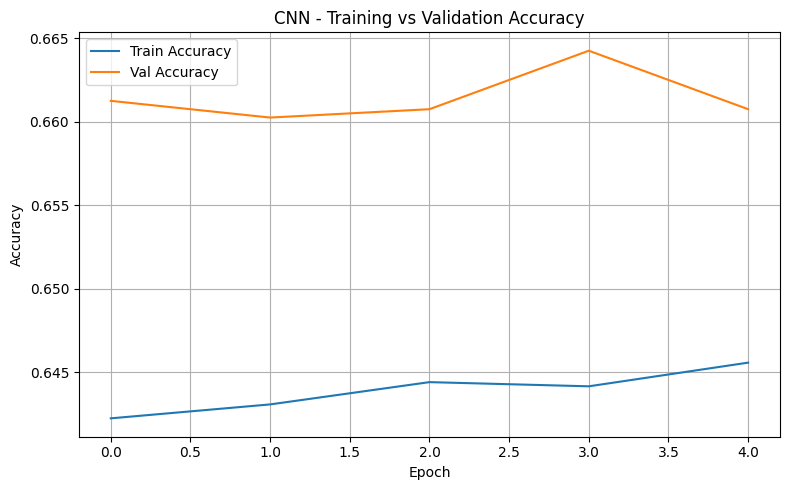

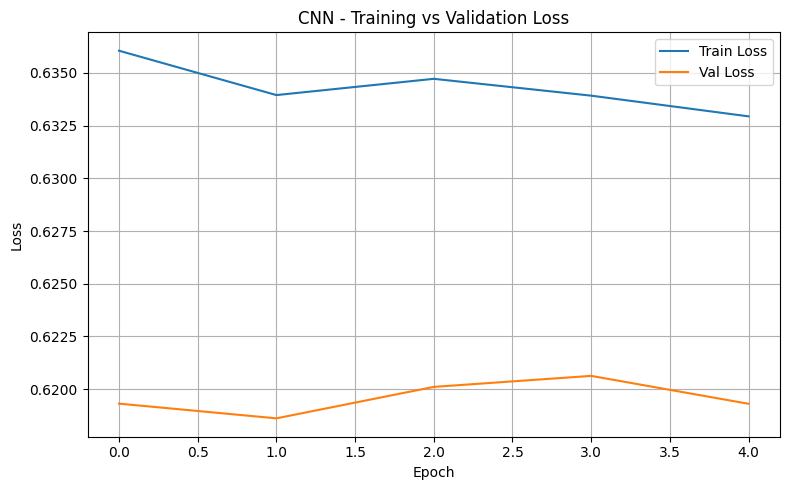

In [13]:
import matplotlib.pyplot as plt
import os

# Ensure /Figures/ exists
fig_dir = '/content/drive/MyDrive/LoanApprovalProject/Figures'
os.makedirs(fig_dir, exist_ok=True)

# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN - Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{fig_dir}/cnn_train_val_accuracy.png')
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('CNN - Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{fig_dir}/cnn_train_val_loss.png')
plt.show()


# Step 7: Evaluate on the Test Set

I’ll now evaluate the CNN-based model on the held-out test set. Metrics include accuracy, precision, recall, F1-score, and ROC AUC. I’ll also generate and save the confusion matrix and ROC curve.


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import numpy as np

# Test inputs
test_inputs = {
    'tabular_input': X_tab_test_cnn,
    'input_ids': X_text_test_tok['input_ids'],
    'attention_mask': X_text_test_tok['attention_mask']
}

# Predict
y_probs = cnn_model.predict(test_inputs)
y_pred = (y_probs > 0.5).astype(int)

# Metrics
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))


125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      2000
           1       0.65      0.60      0.62      2000

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000

ROC AUC: 0.692421


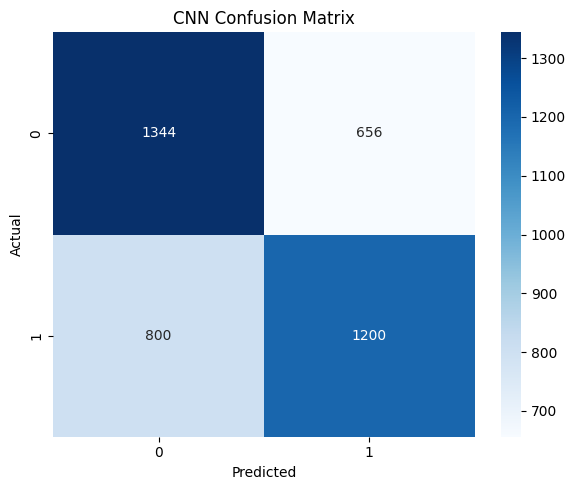

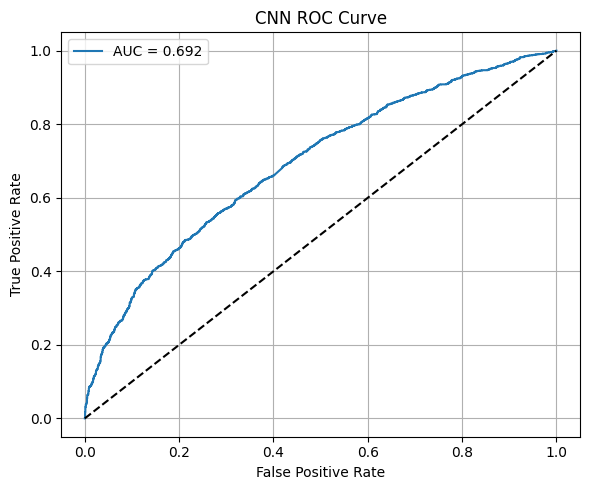

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f'{fig_dir}/cnn_confusion_matrix.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_probs):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{fig_dir}/cnn_roc_curve.png')
plt.show()


###  Evaluation Observations

- The CNN-based model achieved **64% test accuracy** and **0.692 ROC AUC**.
- Precision was slightly higher for class 1 (loan approved), while recall was slightly higher for class 0.
- The confusion matrix shows a moderate trade-off between false positives and false negatives.
- Compared to the DNN model, this CNN model performed reasonably well, but slightly weaker in overall discriminative power.


In [16]:
# Saving the CNN model
cnn_model.save('/content/drive/MyDrive/LoanApprovalProject/Code/cnn_model.h5')
print(" CNN model saved.")


 CNN model saved.
